In [1]:
import pandas as pd
import numpy as np

import pvlib
from pvlib import pvsystem, modelchain
from pvlib.location import Location
from pvlib.iotools import read_epw

import matplotlib.pyplot as plt

from src.facade import *
from src.view_profile import *
from src.site import *
from src.array import FacadeArray

In [2]:
# Building Constants
latitude = -27.48637226
longitude = 153.01796166
tz = 'Australia/Brisbane'


# Building site
site = Site(latitude=latitude, longitude=longitude, tz=tz)

file_test = '/workspace/weather/AUS_QLD_Brisbane.945760_TMYx.2009-2023.epw'
weather_data, metadata = read_epw(file_test)

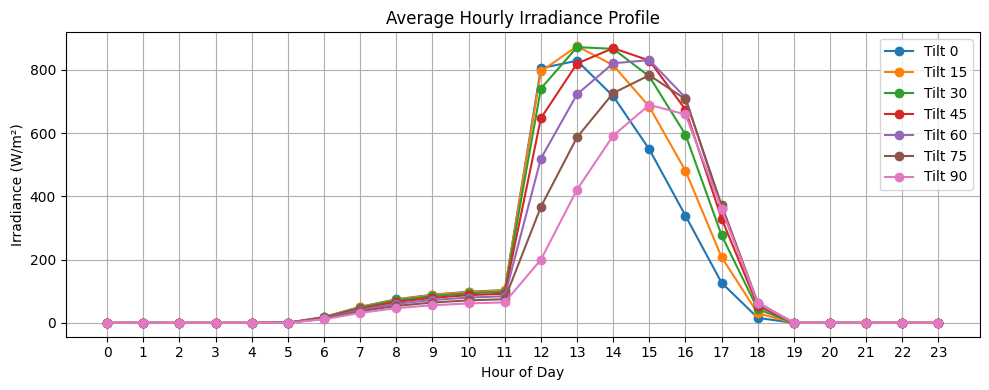

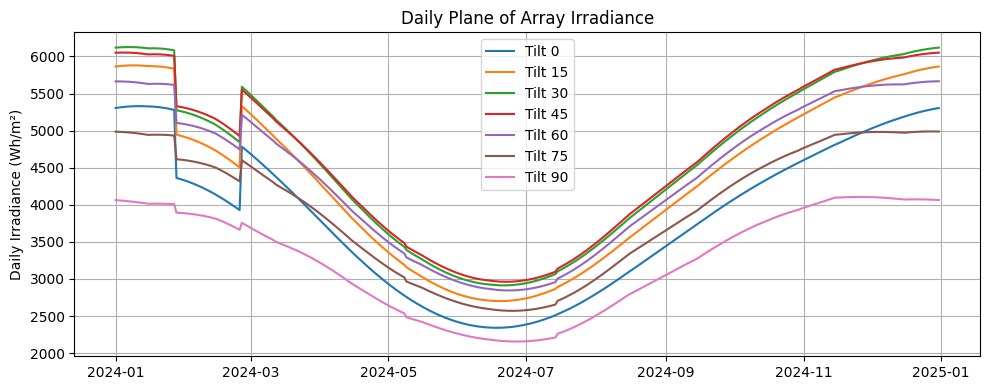

In [3]:
orientation_azimuth = 270

solar_position, site_irradiance = site.generate_clearsky()

fig1, ax1 = plt.subplots(figsize=(10, 4))
fig2, ax2 = plt.subplots(figsize=(10, 4))
for x in range(0, 91, 15):
    facade = Facade(orientation_azimuth, site, profile=BACKED,
                    tilt=x)  # e.g., west-facing in Brisbane
    irradiance_results = facade.solve_irradiance(
        solar_position, site_irradiance)
    irradiance_results.plot_daily_profile(
        figure=fig1, show=False, label=f'Tilt {x}')
    irradiance_results.plot_yearly_irradiance(
        figure=fig2, show=False, label=f'Tilt {x}')

fig1.show()
fig2.show()

### Generate East and West Facades and plot Facade Profile

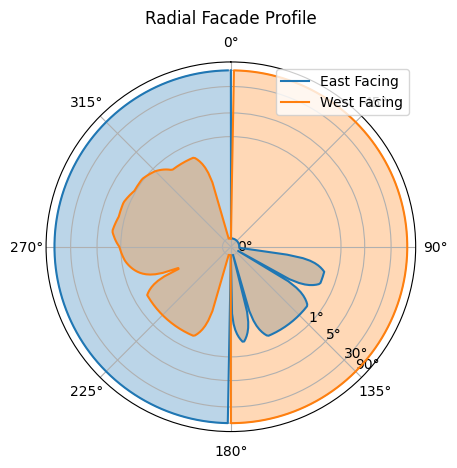

<PolarAxes: title={'center': 'Radial Facade Profile'}>

In [4]:
facade_W = Facade(270, site, profile=BACKED,
                  tilt=90)  # e.g., west-facing in Brisbane
facade_E = Facade(90, site, profile=BACKED,
                  tilt=90)

# Radial Facade Profile of East and West facing facades
ax = facade_E.facade_profile.plot_radial(label='East Facing', show=False)
facade_W.facade_profile.plot_radial(ax=ax, label='West Facing')

## Simulate Facade as a PV array

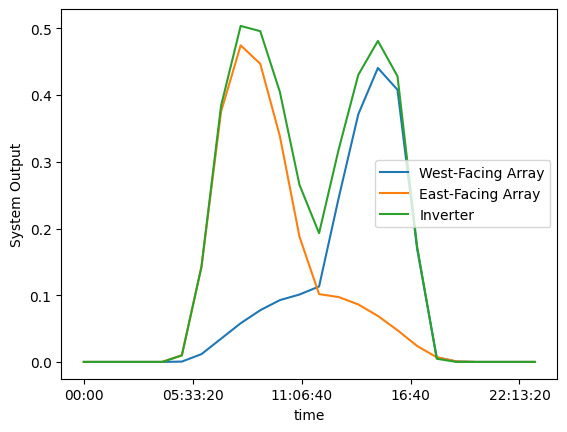

In [5]:
# Test of PV modules simulation
array_kwargs = dict(
    module_parameters=dict(pdc0=1, gamma_pdc=-0.004),
    temperature_model_parameters=dict(a=-3.56, b=-0.075, deltaT=3)
)

arrays = [
    FacadeArray(pvsystem.FixedMount(90, 270),
                name='West-Facing Array', facade_profile=facade_W.facade_profile, **array_kwargs),
    FacadeArray(pvsystem.FixedMount(90, 90),
                name='East-Facing Array', facade_profile=facade_E.facade_profile, **array_kwargs),
]


system = pvsystem.PVSystem(arrays=arrays, inverter_parameters=dict(pdc0=3))
mc = modelchain.ModelChain(system, site.location, aoi_model='physical',
                           spectral_model='no_loss')


mc.run_model(weather_data)

fig, ax = plt.subplots()
for array, pdc in zip(system.arrays, mc.results.dc):
    pdc.groupby(
        pdc.index.time
    ).mean().plot(label=f'{array.name}')

inverter = mc.results.ac
inverter.groupby(inverter.index.time).mean().plot(label='Inverter')
plt.ylabel('System Output')
plt.legend()
plt.show()